## Load and Clean Multiple EEG Files

We'll load all six .txt files and clean the data by skipping metadata, extracting numeric columns, and converting them into NumPy arrays for further analysis.

In [2]:
import pandas as pd
import numpy as np

# Define file names
filenames = ['HR_01.txt', 'HR_02.txt', 'SL_01.txt', 'SL_02.txt', 'SK_01.txt', 'SK_02.txt']

# Function to load and clean data
def load_eeg_data(filename):
    data = pd.read_csv(filename, delimiter=',', skiprows=4)  # Adjust skiprows based on file structure
    numeric_data = data.select_dtypes(include=[np.number])
    return numeric_data.to_numpy()

# Load and store data from all files
eeg_data = {name: load_eeg_data(name) for name in filenames}

# Print the shape of one dataset to verify
print(eeg_data['HR_01.txt'].shape)


(30355, 24)


### Step 2: Preprocess EEG Data (Bandpass Filtering)

Apply a bandpass filter to isolate the EEG signal between 0.5 Hz and 50 Hz, which is relevant for mental fatigue or stress analysis.



In [5]:
from scipy.signal import butter, filtfilt

# Define bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

# Set sampling rate and filter parameters
sampling_rate = 256  # Adjust based on actual sampling rate
lowcut = 0.5  # Hz
highcut = 50  # Hz

# Apply filter to all EEG data
filtered_eeg_data = {name: apply_bandpass_filter(data, lowcut, highcut, sampling_rate) for name, data in eeg_data.items()}

# Check shape of filtered data
print(filtered_eeg_data['HR_01.txt'].shape)


(30355, 24)


###  Perform FFT and Spectral Analysis

Compute FFT for each EEG channel to analyze frequency components in the signal.

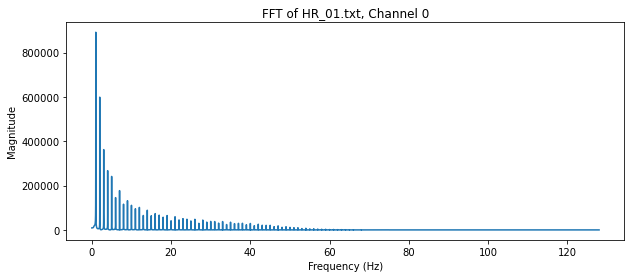

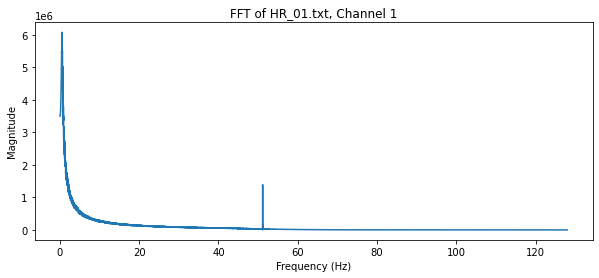

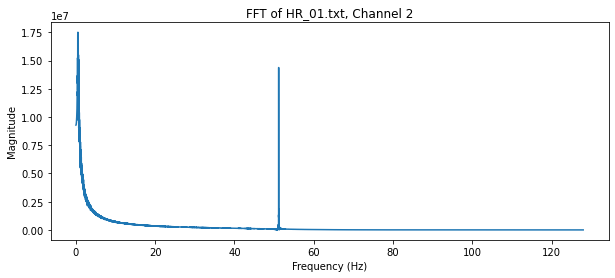

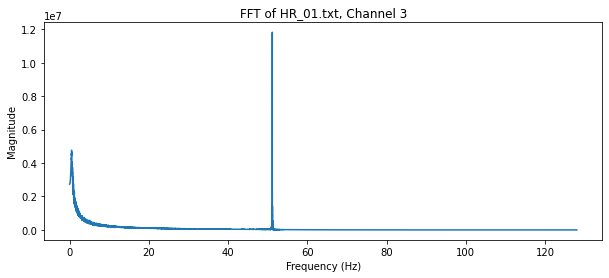

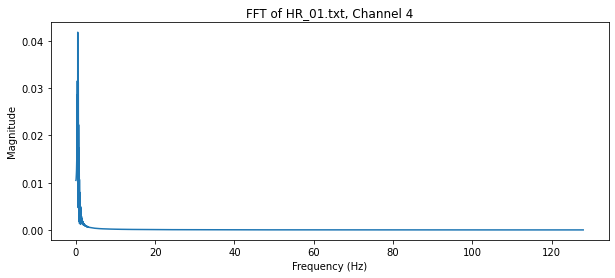

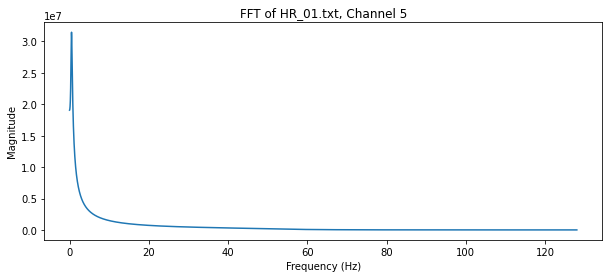

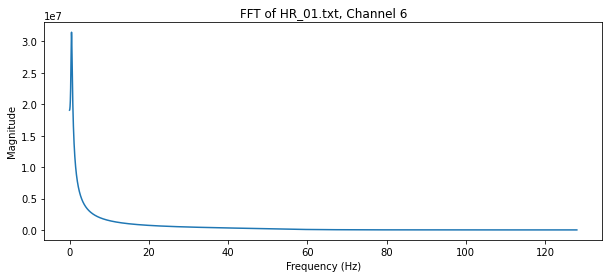

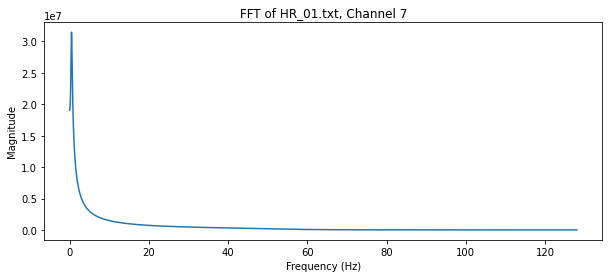

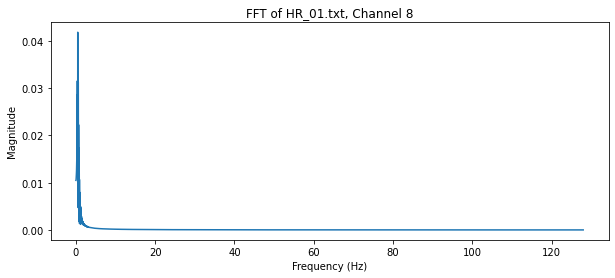

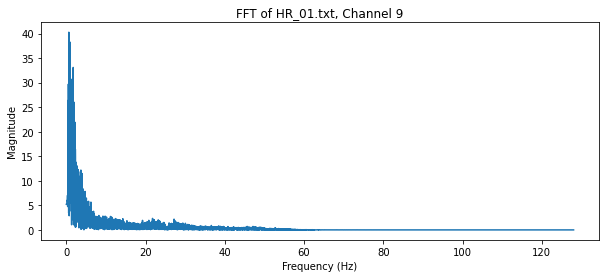

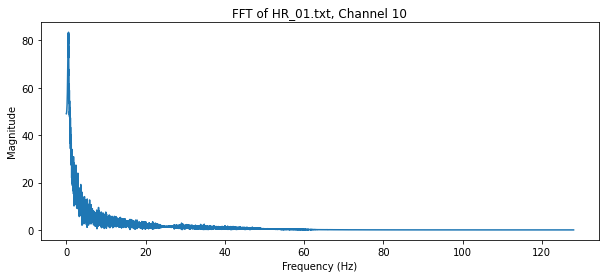

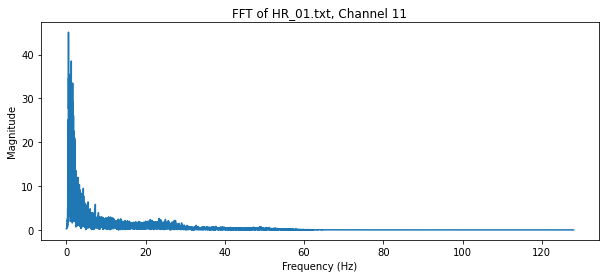

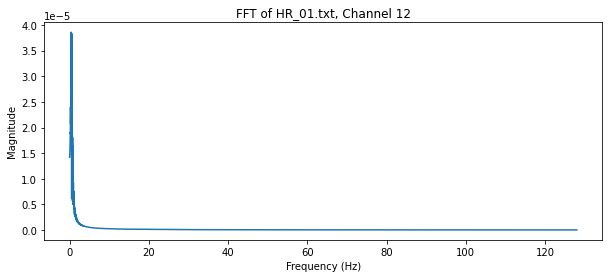

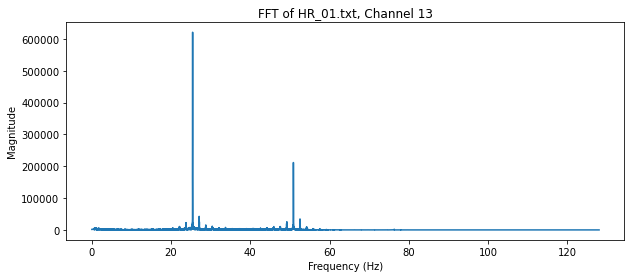

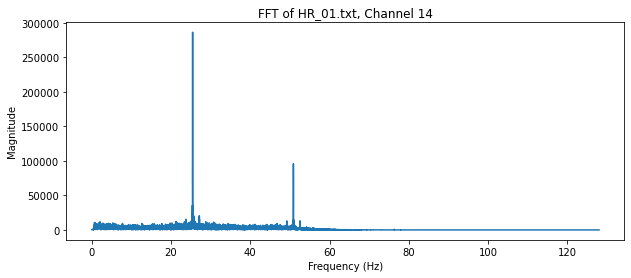

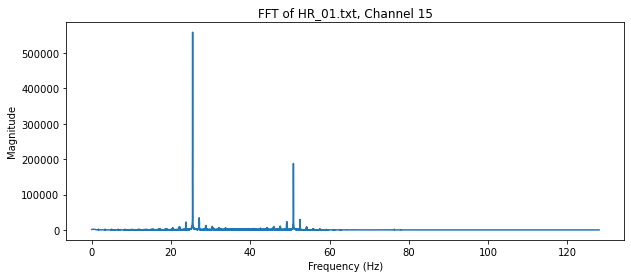

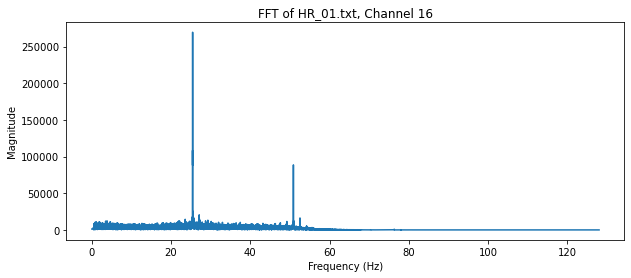

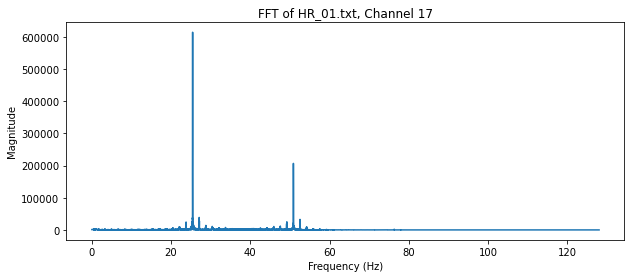

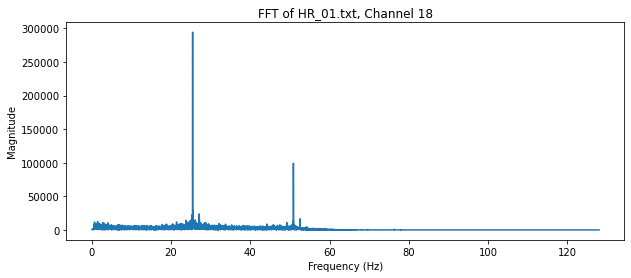

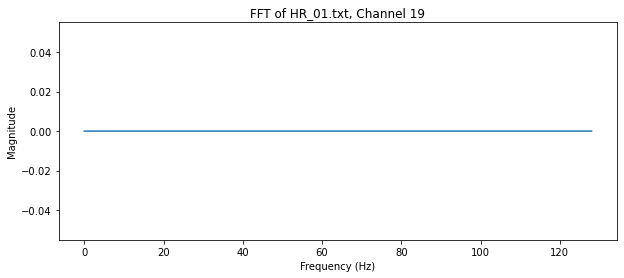

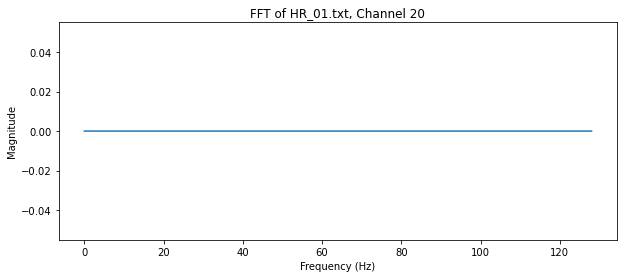

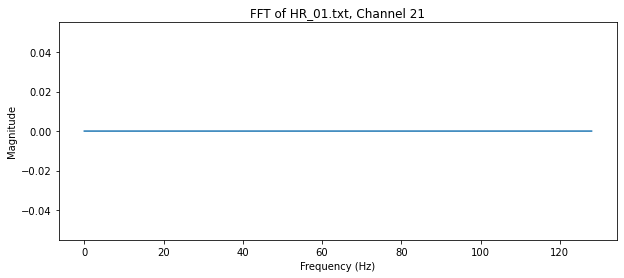

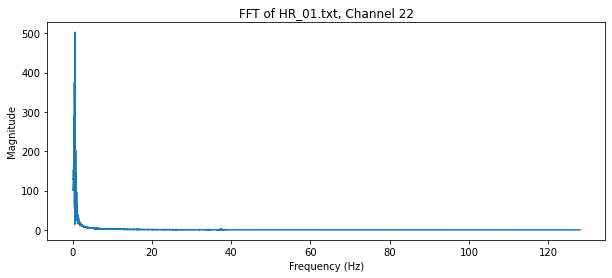

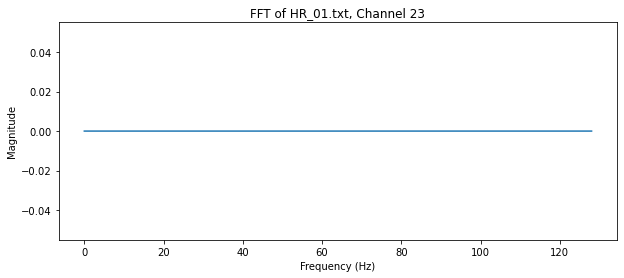

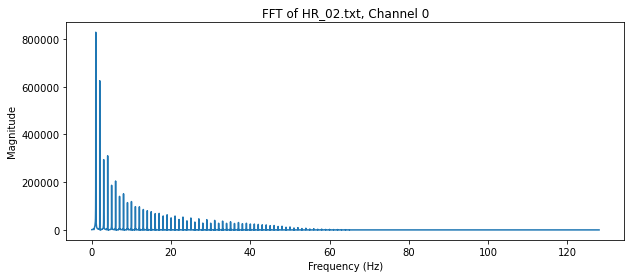

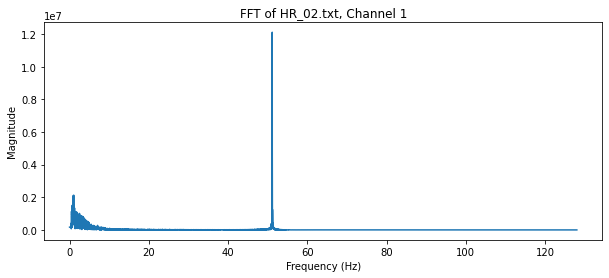

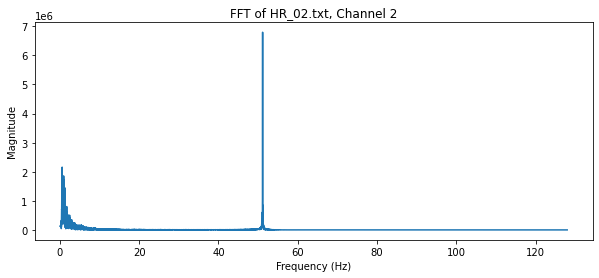

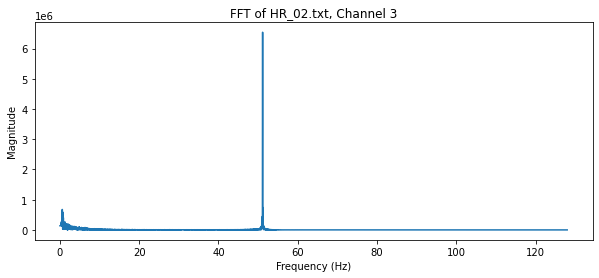

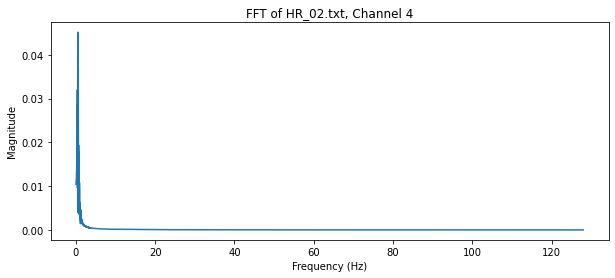

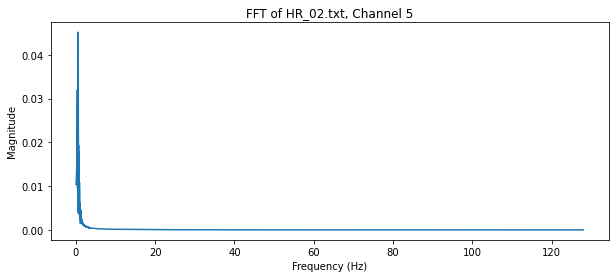

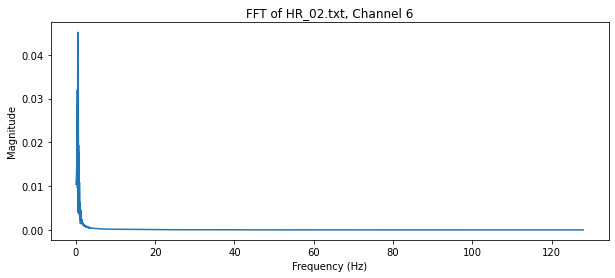

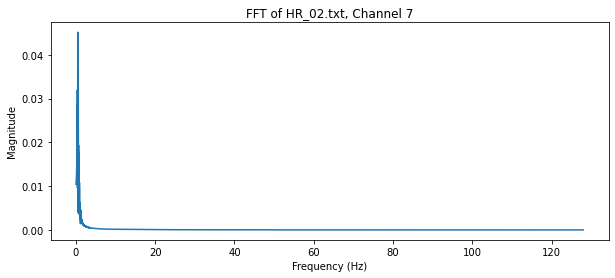

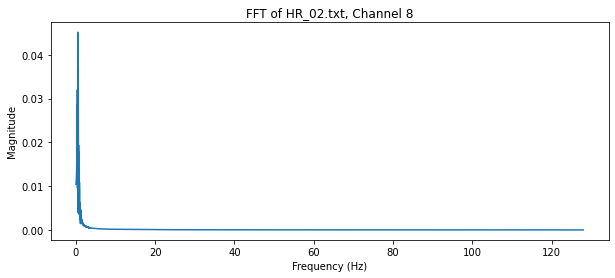

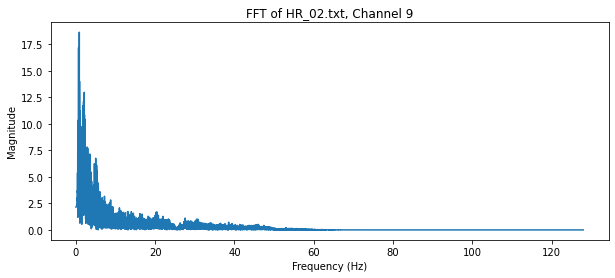

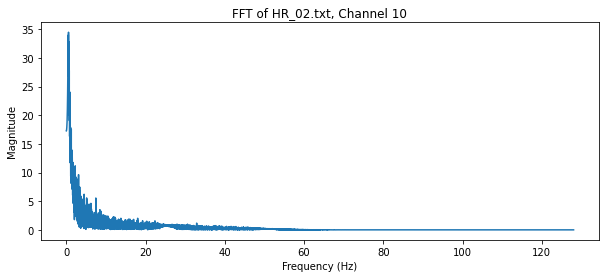

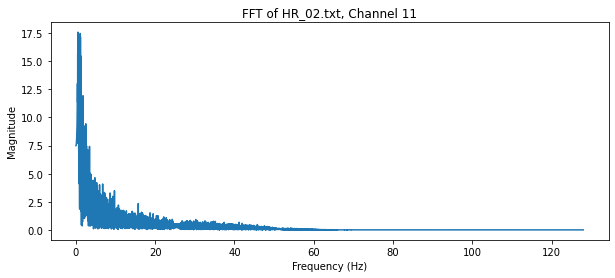

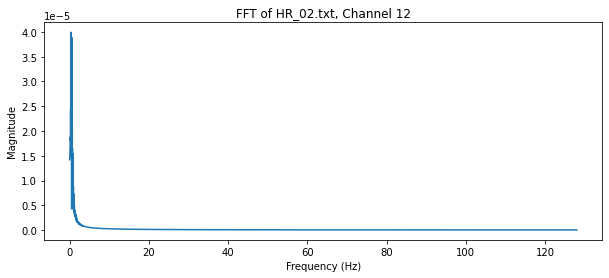

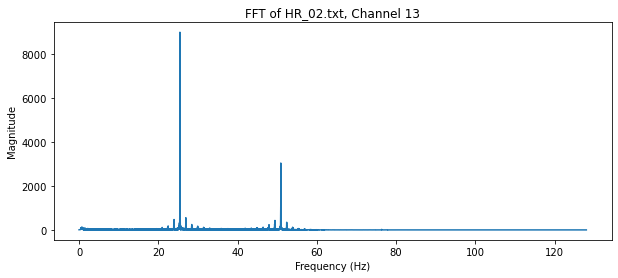

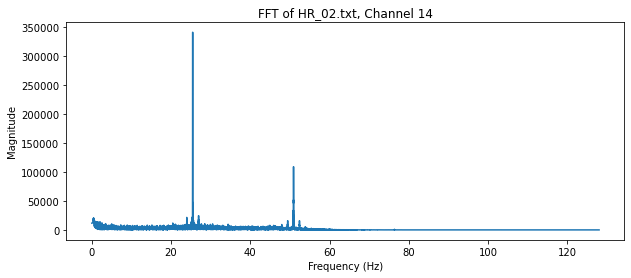

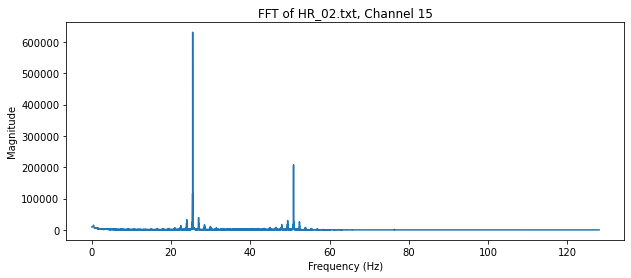

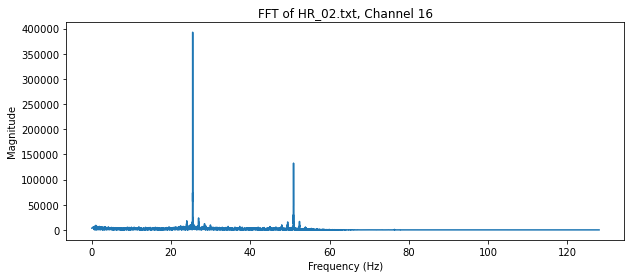

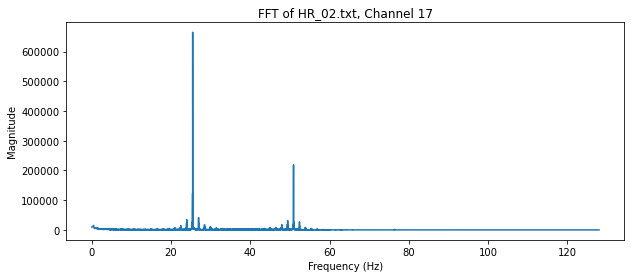

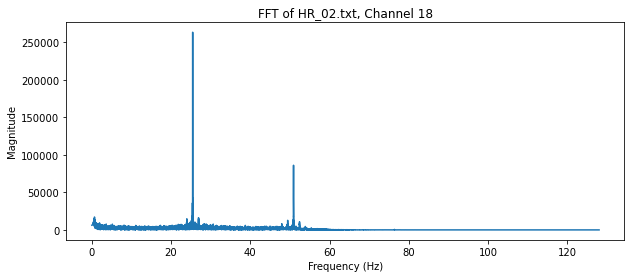

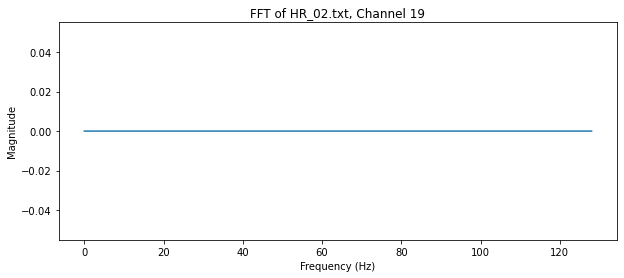

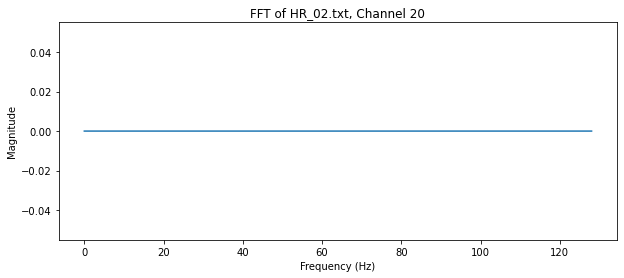

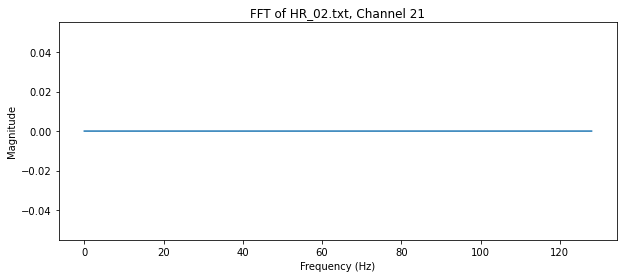

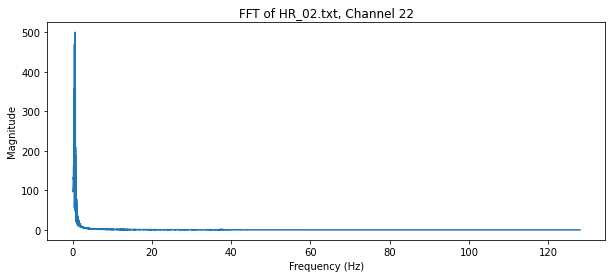

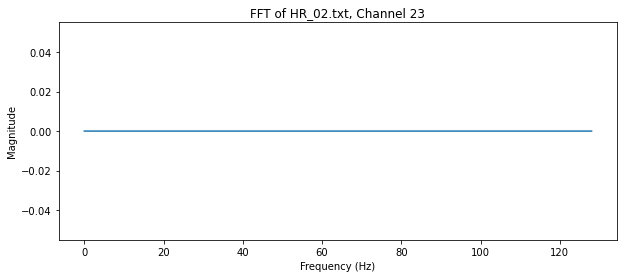

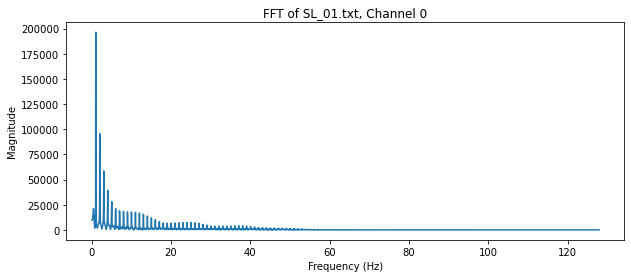

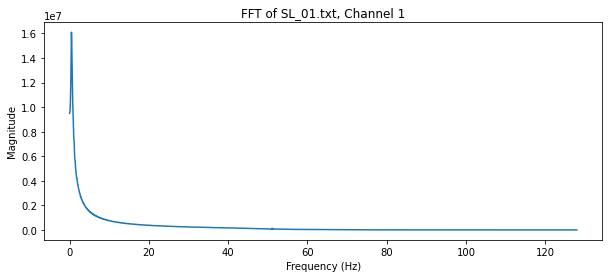

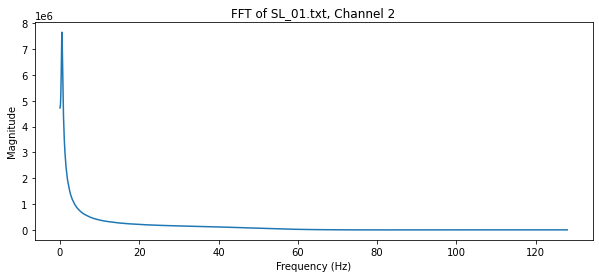

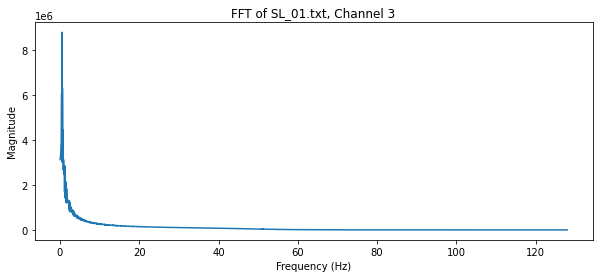

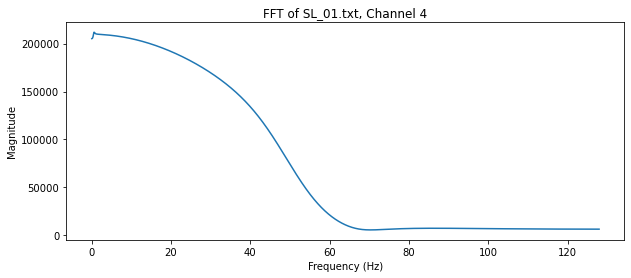

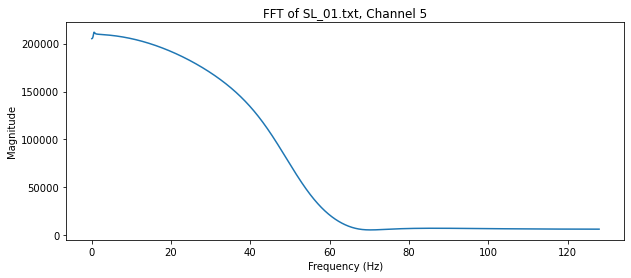

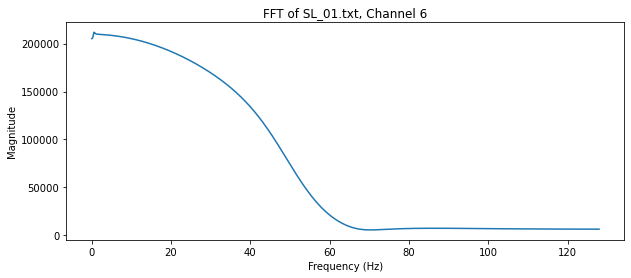

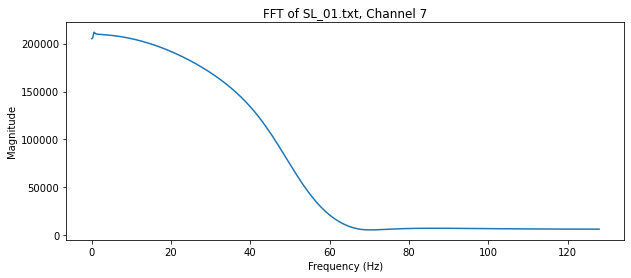

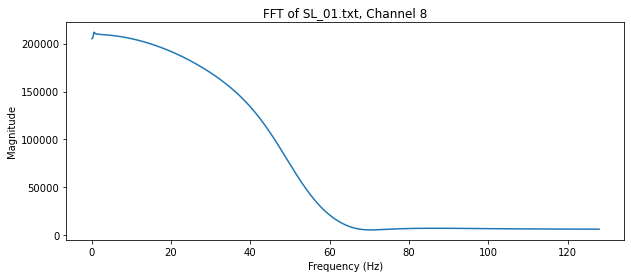

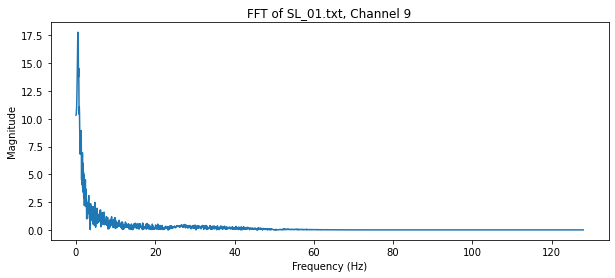

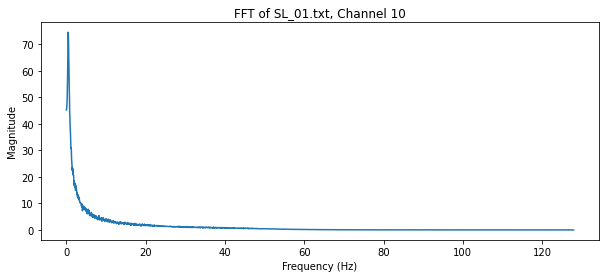

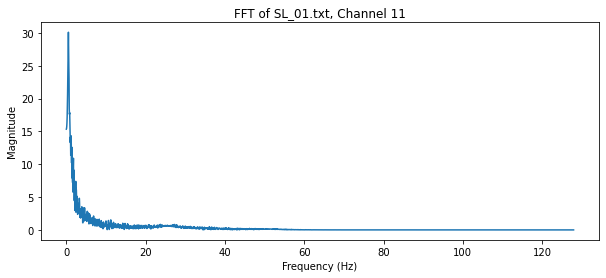

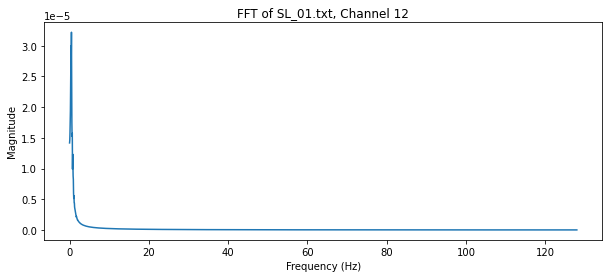

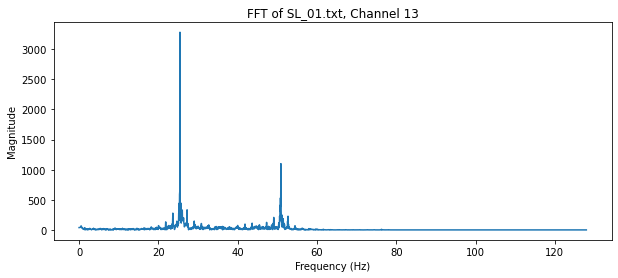

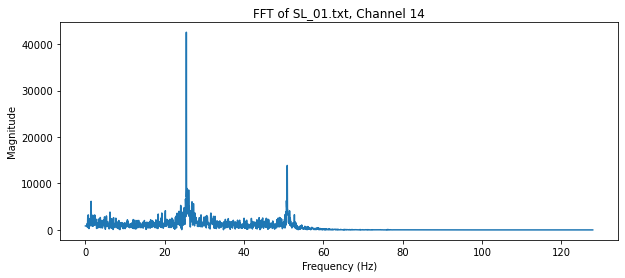

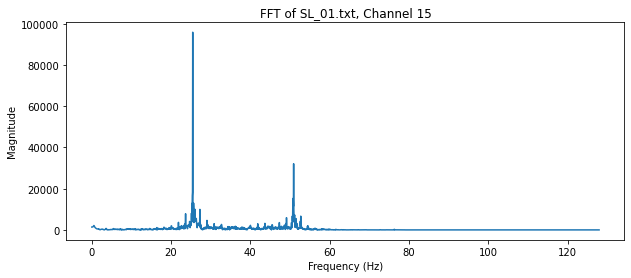

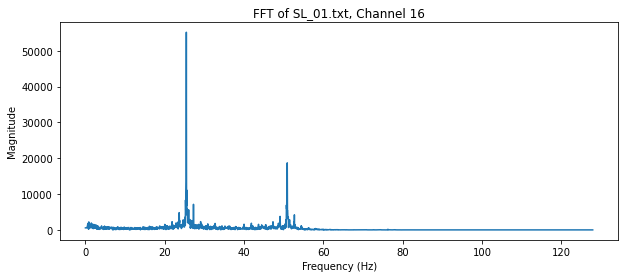

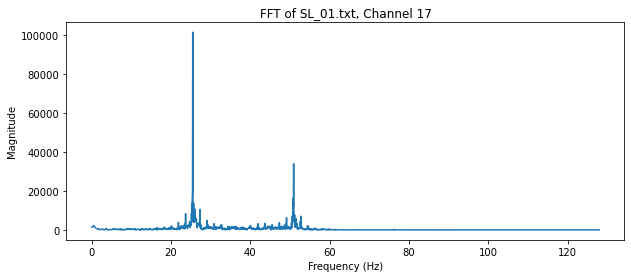

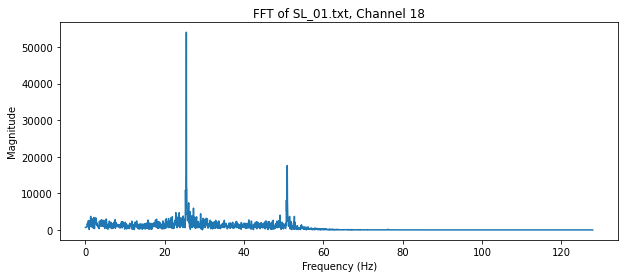

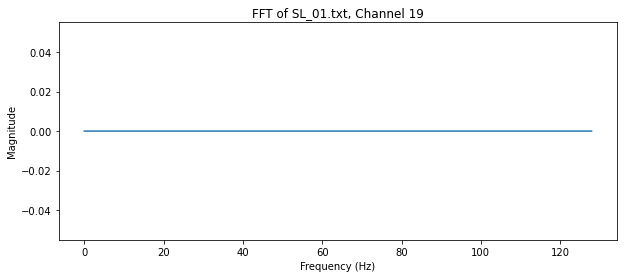

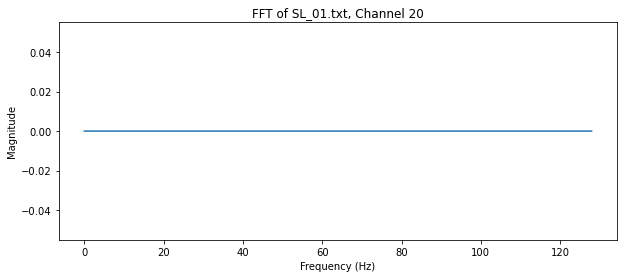

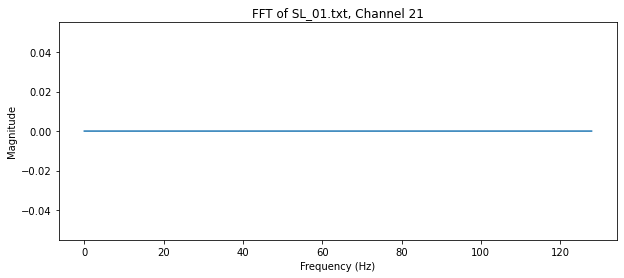

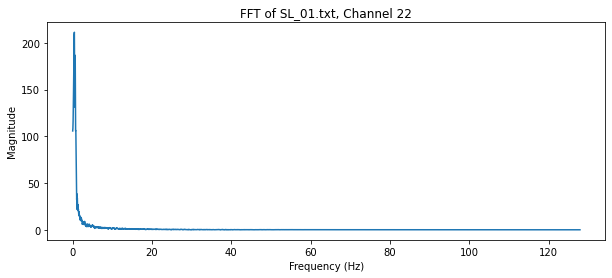

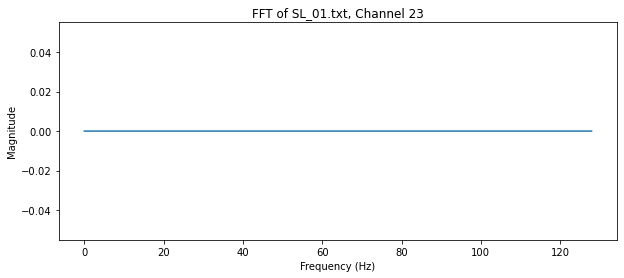

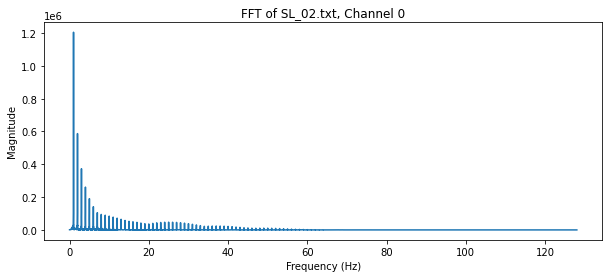

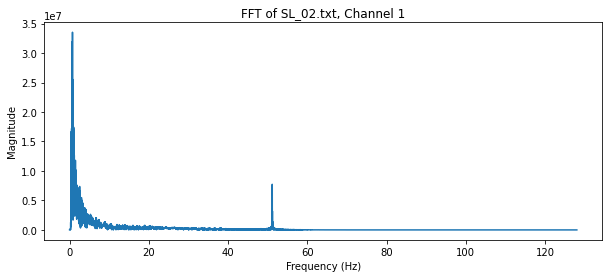

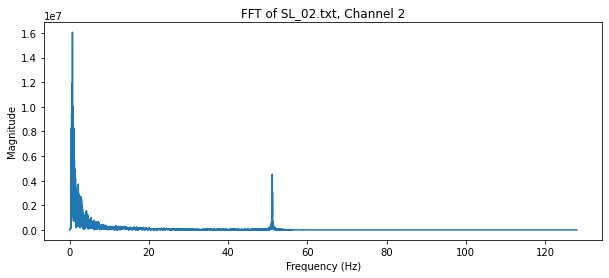

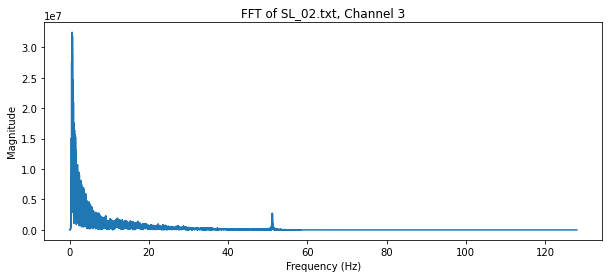

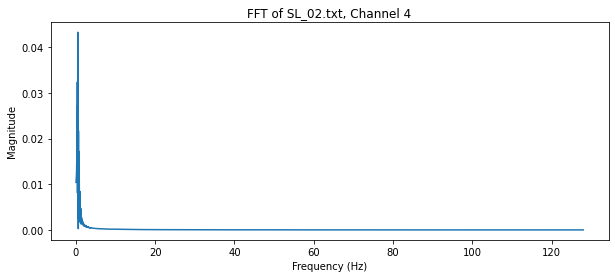

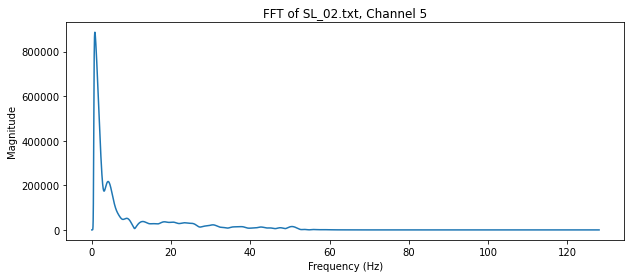

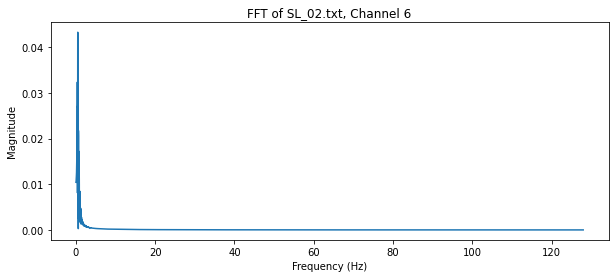

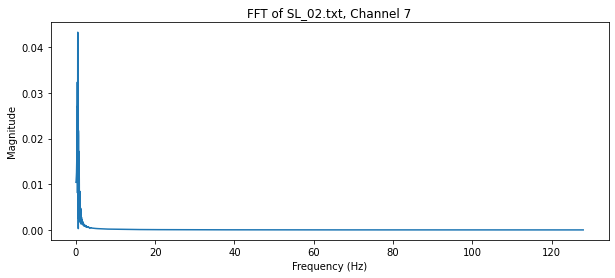

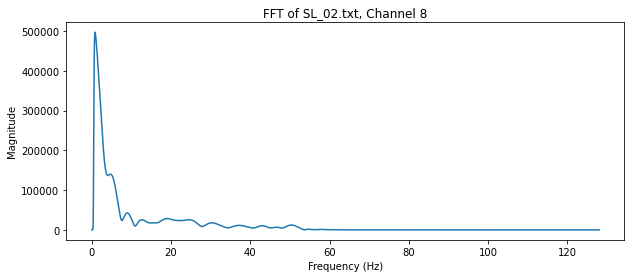

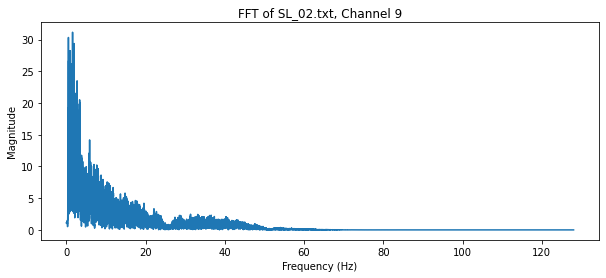

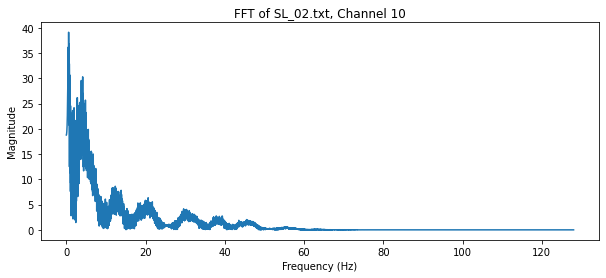

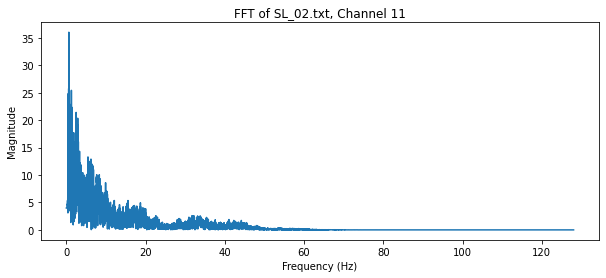

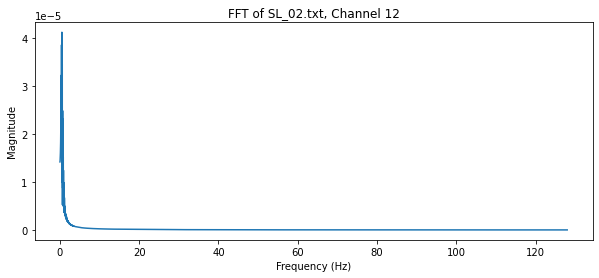

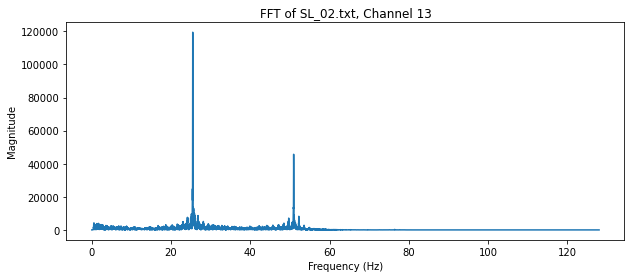

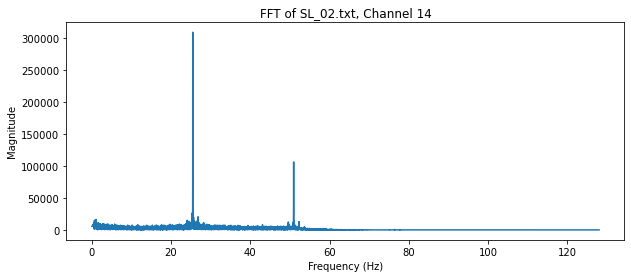

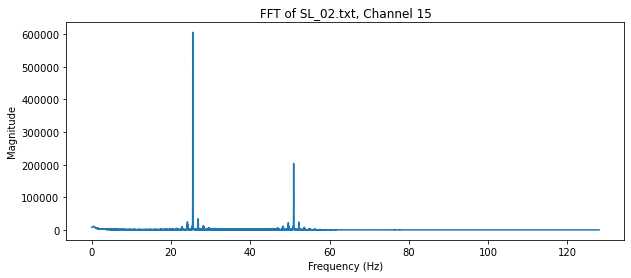

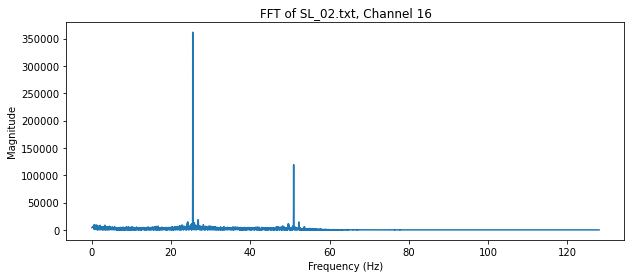

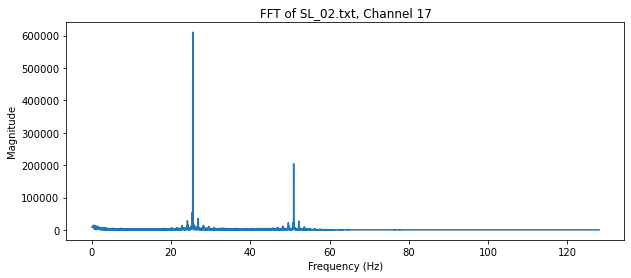

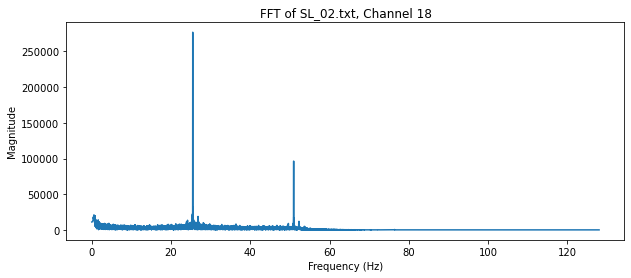

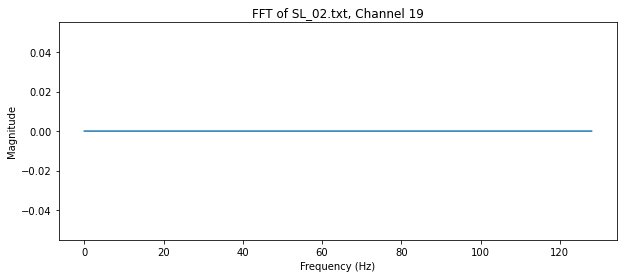

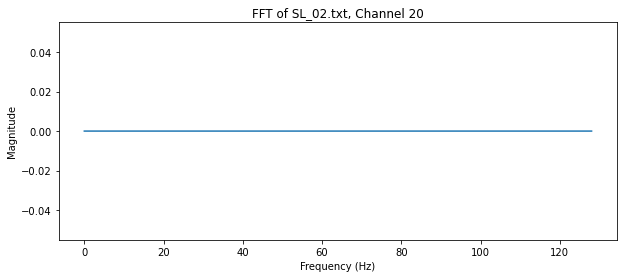

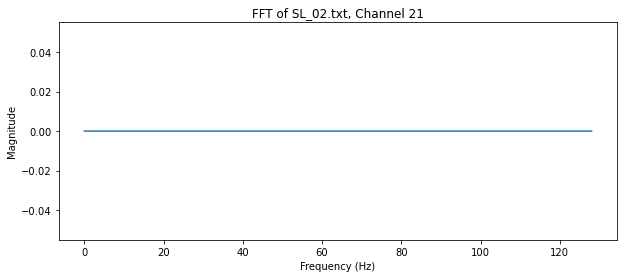

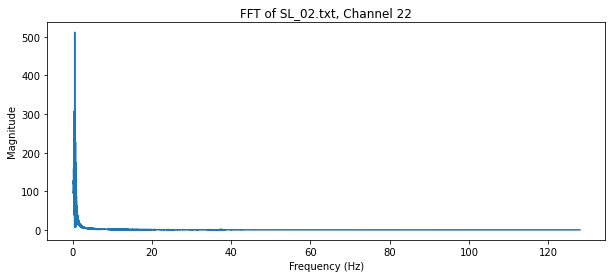

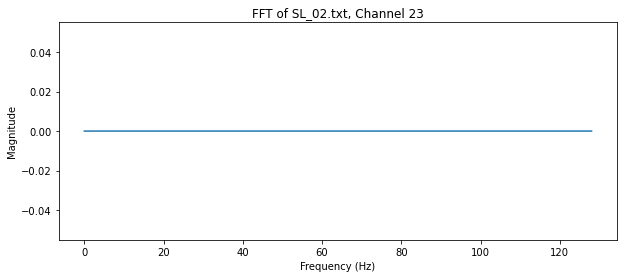

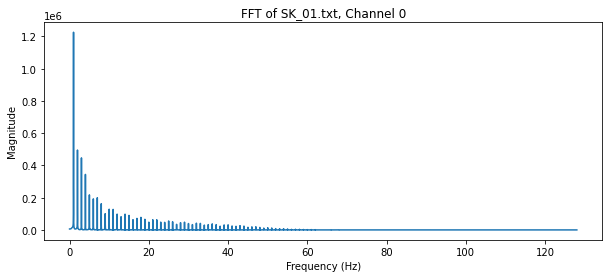

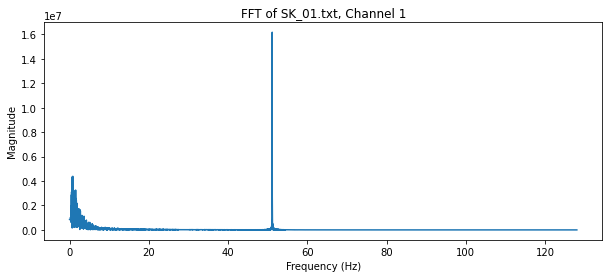

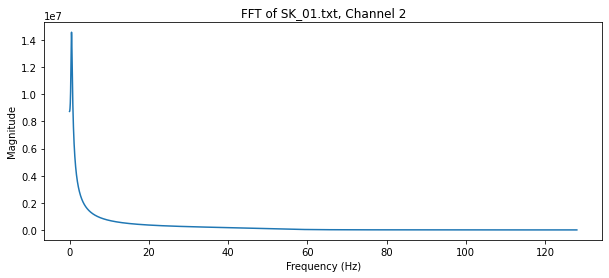

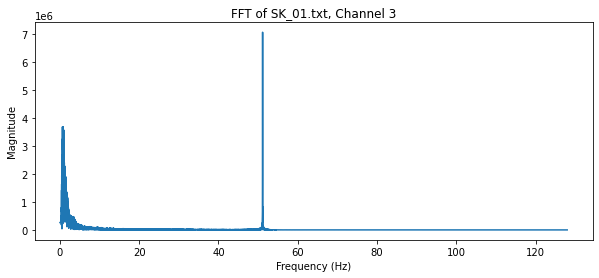

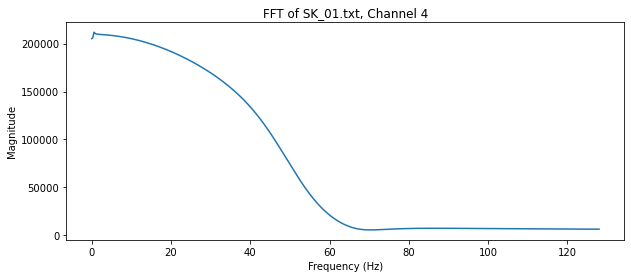

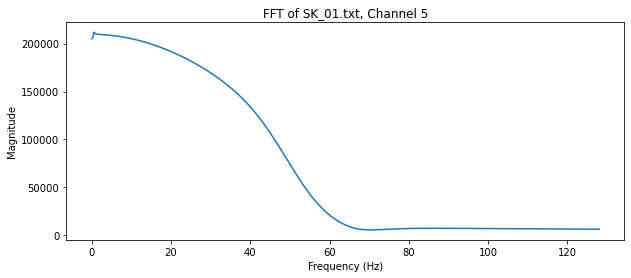

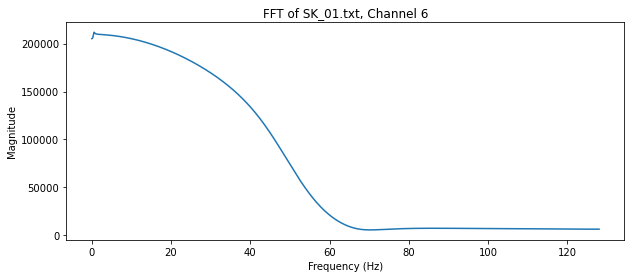

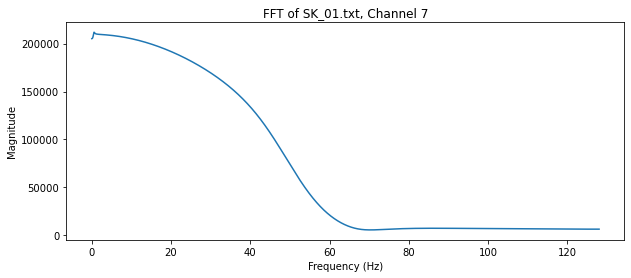

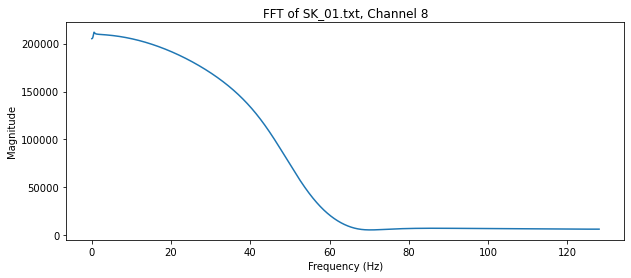

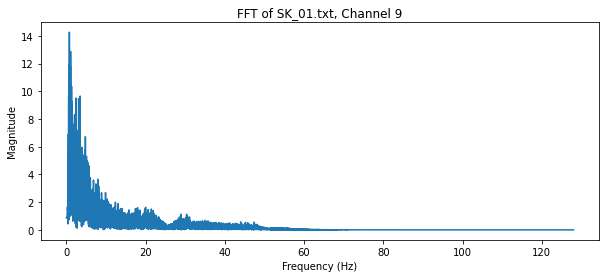

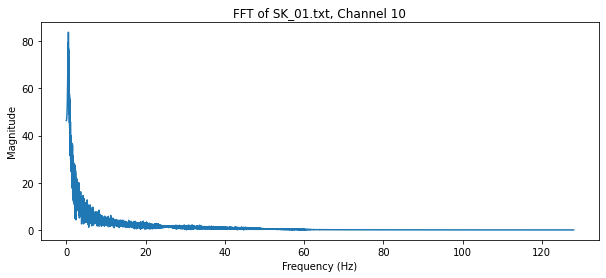

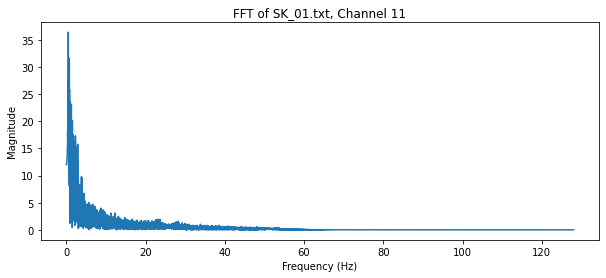

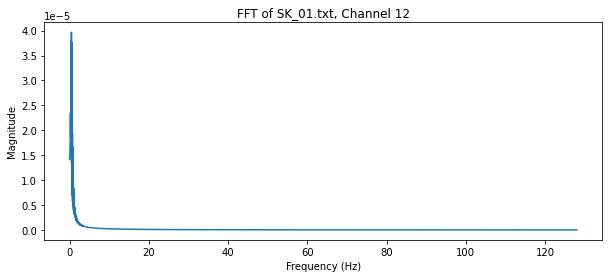

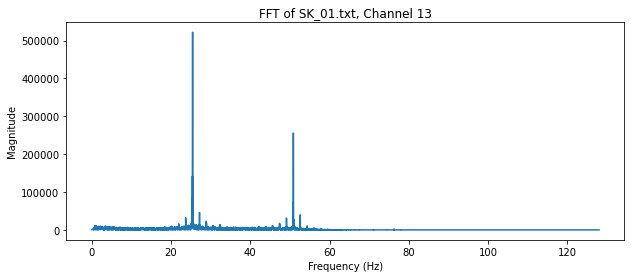

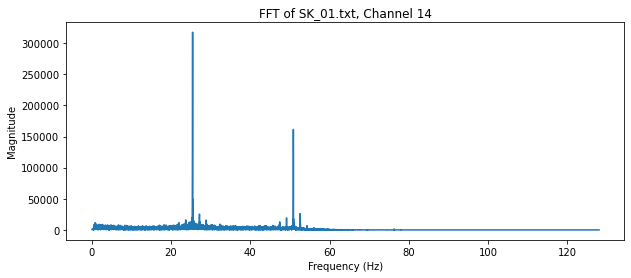

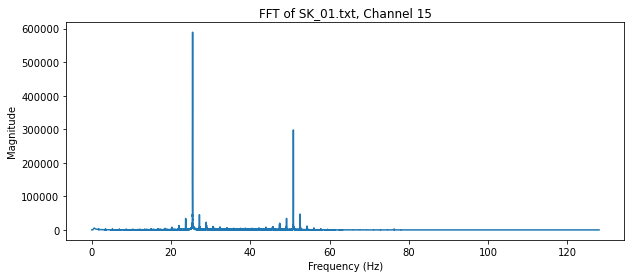

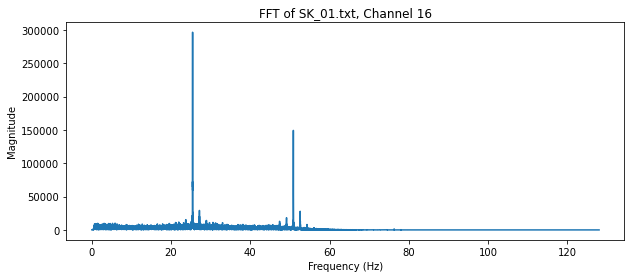

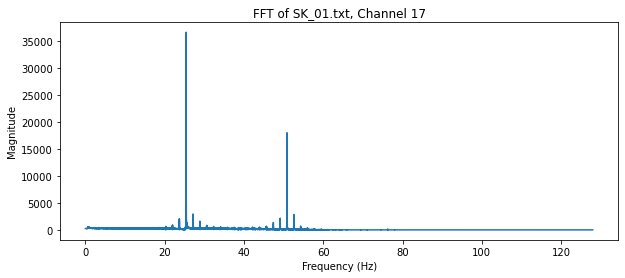

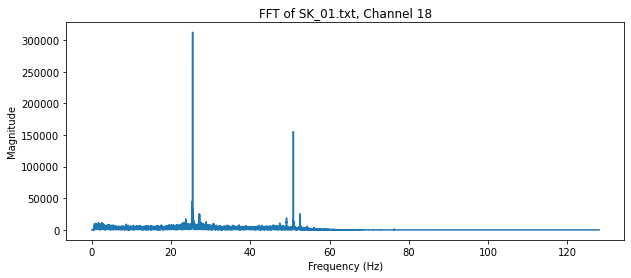

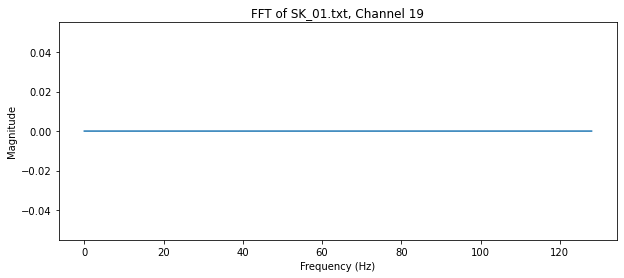

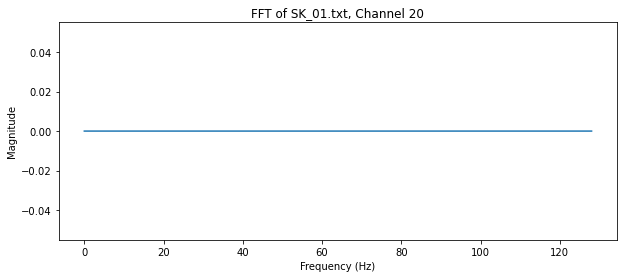

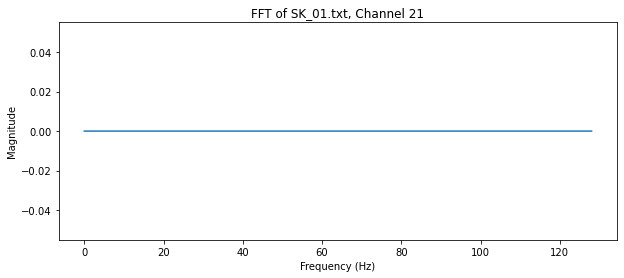

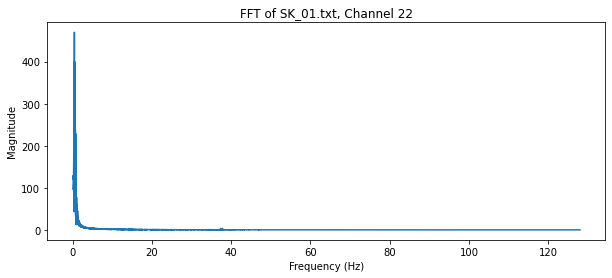

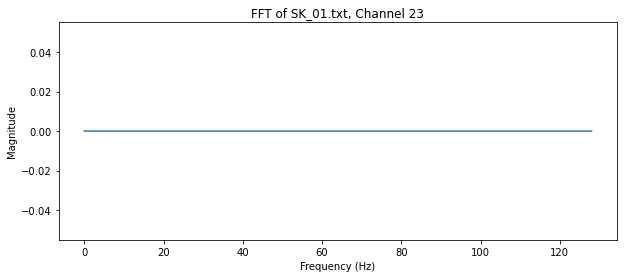

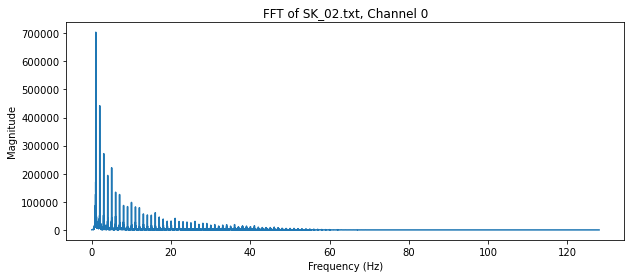

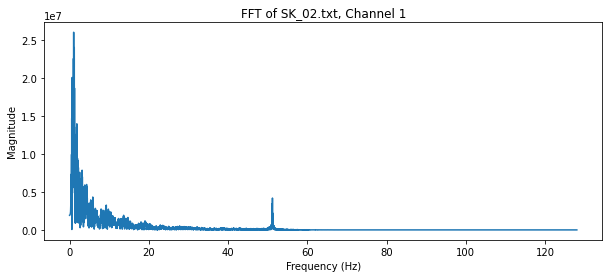

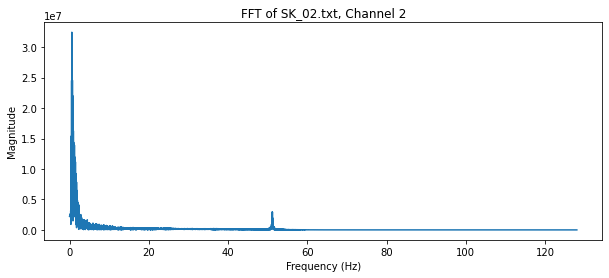

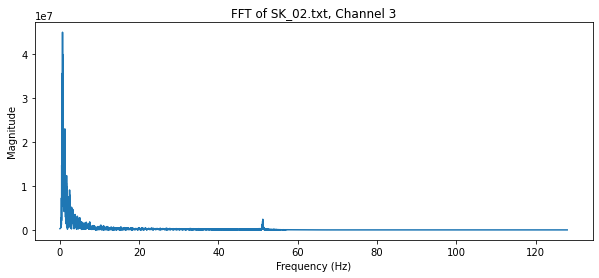

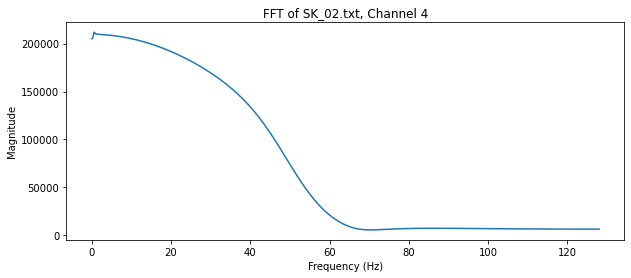

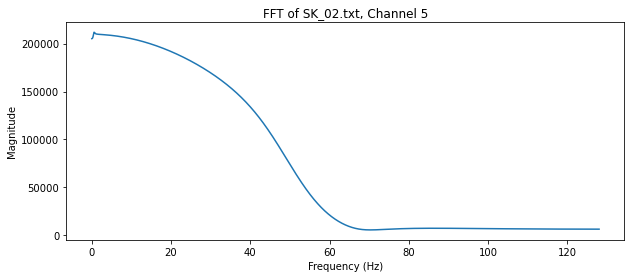

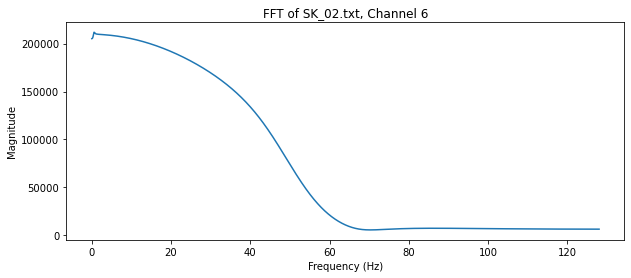

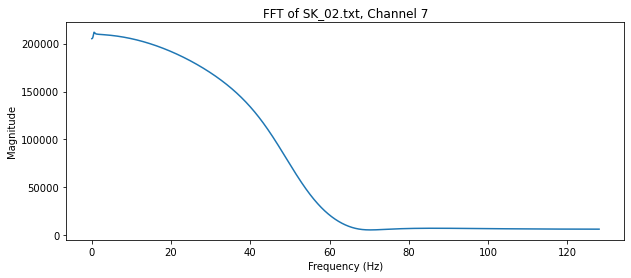

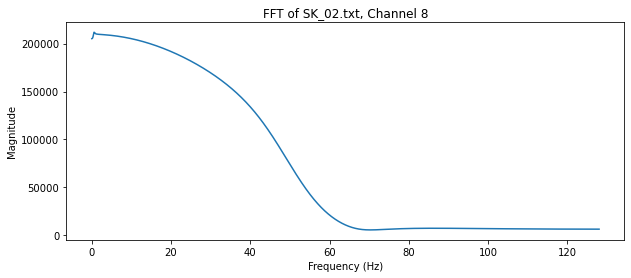

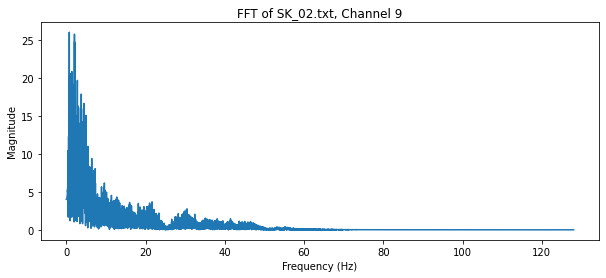

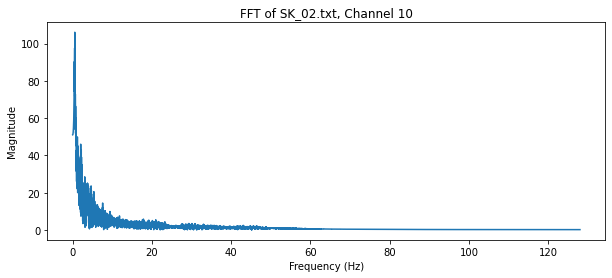

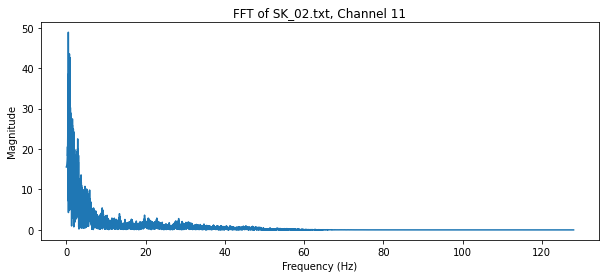

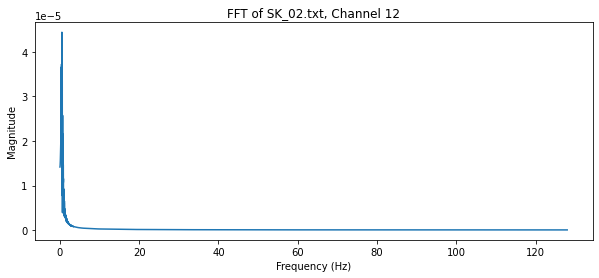

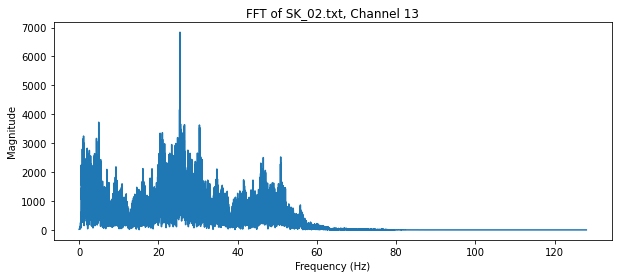

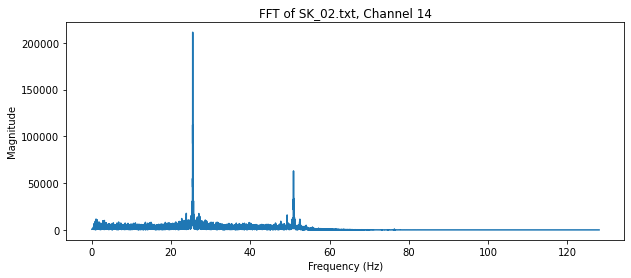

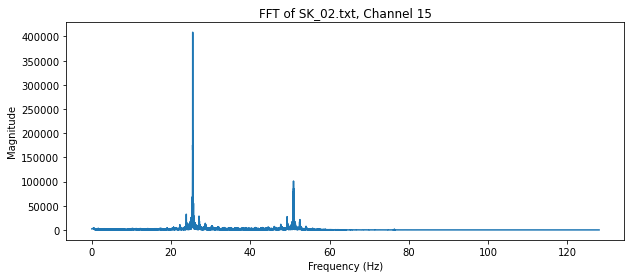

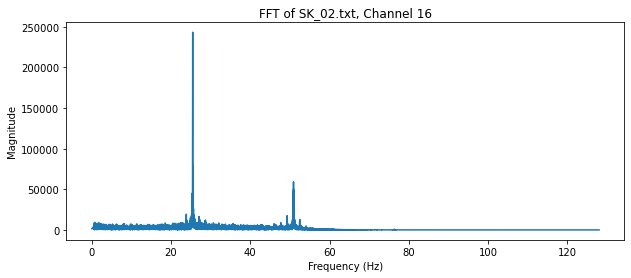

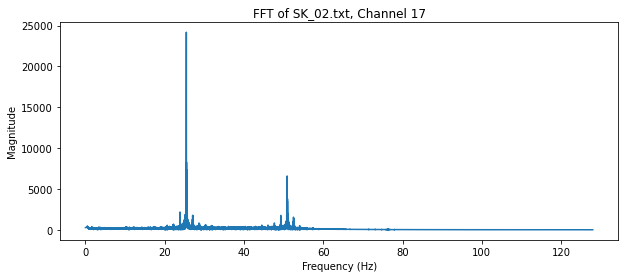

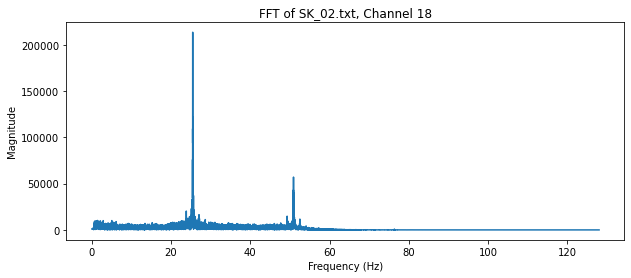

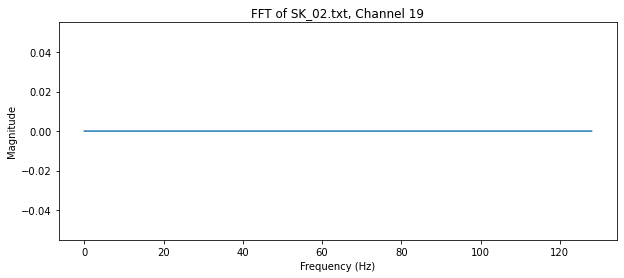

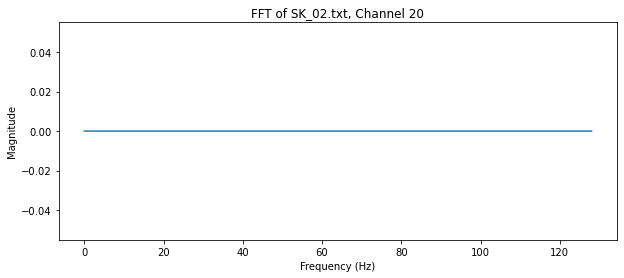

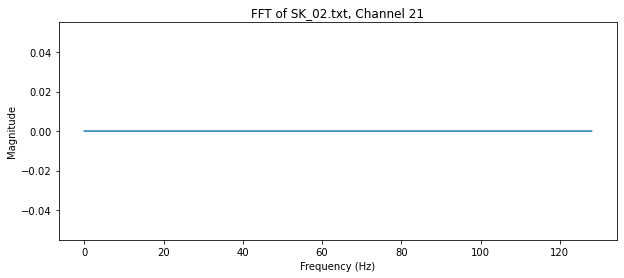

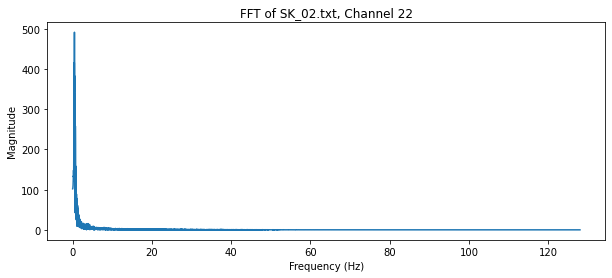

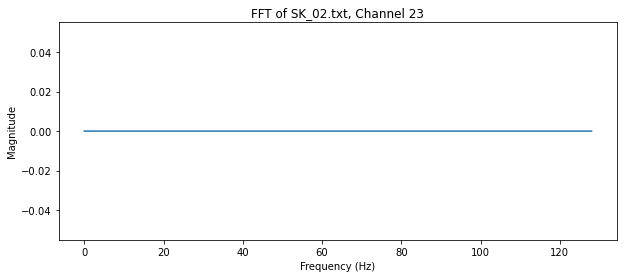

In [6]:
import matplotlib.pyplot as plt

# FFT function
def compute_fft(data, fs):
    n = len(data)
    freqs = np.fft.fftfreq(n, 1/fs)
    fft_values = np.fft.fft(data)
    fft_magnitude = np.abs(fft_values)
    return freqs[:n // 2], fft_magnitude[:n // 2]

# Perform FFT for each file and channel
for name, data in filtered_eeg_data.items():
    for channel in range(data.shape[1]):
        freqs, fft_magnitude = compute_fft(data[:, channel], sampling_rate)
        # Plot FFT
        plt.figure(figsize=(10, 4))
        plt.plot(freqs, fft_magnitude)
        plt.title(f'FFT of {name}, Channel {channel}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.show()


##  Feature Extraction (Band Power)

Extract power from different EEG frequency bands to quantify brain activity related to mental fatigue or stress.

In [7]:
# Function to calculate band power
def bandpower(data, freqs, low, high):
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(data[idx_band])

# Define frequency bands
bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 50)}

# Extract features for each file
features = {}
for name, data in filtered_eeg_data.items():
    feature_matrix = []
    for channel in range(data.shape[1]):
        freqs, fft_magnitude = compute_fft(data[:, channel], sampling_rate)
        feature_vector = [bandpower(fft_magnitude, freqs, low, high) for band, (low, high) in bands.items()]
        feature_matrix.append(feature_vector)
    features[name] = np.array(feature_matrix)

# Check extracted features
print(features['HR_01.txt'].shape)


(24, 5)


### : Labeling the Data 

Assign labels to the data based on the time intervals (morning = relaxed, evening = stressed).

In [10]:
# Define labels for each measurement
labels = {'HR_01.txt': 0, 'HR_02.txt': 1, 'SL_01.txt': 0, 'SL_02.txt': 1, 'SK_01.txt': 0, 'SK_02.txt': 1}


##  Machine Learning for Stress Prediction

Apply a machine learning classifier (Random Forest) to predict stress levels from the extracted features.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare features and labels for ML
X = np.concatenate([features[name] for name in filenames])
y = np.array([labels[name] for name in filenames for _ in range(features[name].shape[0])])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy * 100:.2f}%')


Model accuracy: 70.45%


## Compare Morning and Evening Data

Analyze the difference between morning and evening EEG data by comparing band power values.

In [ ]:
# for name in ['HR_01.txt', 'HR_02.txt']:
    print(f"Band Power for {name}:")
    print(features[name])

    
    

    
    

    

### Evaluate and Interpret Results

After training and testing the machine learning model, interpret the model's accuracy and the feature differences between morning and evening sessions. If the evening sessions show higher power in stress-related bands (like beta and gamma), it indicates mental fatigue.

## Conclusion
#### This complete process covers:

#### Data loading  and cleaning from multiple .txt files.
###### Bandpass filtering to remove noise.
###### FFT analysis to convert EEG signals into the frequency domain.
 ##### Feature extraction from different EEG bands.
###### Machine learning to classify mental states.
###### Comparison of morning vs. evening EEG data to assess stress.
###### This approach allows you to measure mental fatigue or stress using EEG data and machine learning.






